In [42]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy
import matplotlib.pyplot as plt 
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# 1) Data Preparation

#### 1.1) Download and Split the data

In [2]:
# These transforms will be performed on every datapoint - in this example we want to 
# transform every datapoint to a Tensor datatype, and perform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw



In [46]:
# fast dataset review 

# Tensor dimentionality vizualization 
print("train:", mnist_train[0][0].shape[1])
print("val:", mnist_val[0][0].shape)
print("test:", mnist_test[0][0].shape)


# labels 
print("train labels :", mnist_train.dataset.targets[5])
print("val labels :", mnist_val.dataset.targets.unique())
print("test labels:", mnist_test.targets.unique())

train: 28
val: torch.Size([1, 28, 28])
test: torch.Size([1, 28, 28])
train labels : tensor(2)
val labels : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


#### 1.2) Batch Size and Data Loaders

In [3]:
# DataLoaders  with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


# 2) Hyperparamentes and model definition 
#### 2.1) HyperParameters

In [28]:
# device : set gpu for faster computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters 
# model architecture 

input_size = mnist_train[0][0].shape[1] * mnist_train[0][0].shape[2]
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 10

# external training parameters

batch_size = 10
learning_rate = 0.001
num_epochs = 50

#### 2.2) Model definition

In [47]:

# Simple three-hidden-layer classification model
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )
     # output neuron activation is performed by the cross entropy function 
    def forward(self, x):
        return self.layers(x)

three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)   

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


# 3) Train the model
#### 3.1) Training Function

In [49]:
# Hint! In the Module 3 Introduction to Pytorch notebook, the Network
# we created required the input data to be of shape Nx1 where N is the number of
# features. Currently, our MNIST dataset is shape 28x28 as they are images. Use 
# this code snippet as you iterate through the datapoint in your dataset to flatten
# them so it is size 784x1 and can be used with the models we designed previously!



# training function 
def train_model(model, dataloaders, dataset_sizes,
                criterion, optimizer, scheduler , num_epochs = 25):
    
    # sets initial time stamp (for measuring code time) 
    since = time.time()
    
    # store the best weigths separately
    best_model_wts = copy.deepcopy(model.state_dict()) 

    best_acc = 0.0
    best_epoch = 0 
    
    
    
    phases = ['train','val','test']
    
    # keep track of how loss and acuraccy evolves during training 
   
    training_curves = {}
    for phase in phases: 
        training_curves[phase + '_loss'] = []
        training_curves[phase + '_acc'] = []
        
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in phases:
            # set model in training mode
            
            if phase == 'train':
                model.train() 
        
            else :
            
                # set model to evaluate mode
                model.eval() 
            
            running_loss = 0.0
            running_corrects = 0
        
            # iterate over the inputs and the labels tensors in the data loader
            for inputs, labels in dataloaders[phase]:
        
                # This flattens every every batch to the correct size!
                inputs = inputs.view(inputs.shape[0],-1)    
                # ensure all datapoints are flattened before feeding them into the model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # reset gradients to 0 
                optimizer.zero_grad()
                
                # forward 
                # enables gradient calculation at train phase 
                with torch.set_grad_enabled(phase == 'train'): 
                    # compute the outputs
                    outputs = model(inputs) 
                    # store the index of the class predicted 
                    _, predictions = torch.max(outputs , 1) 
                    # compute the loss 
                    loss = criterion(outputs,labels) 
                
                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics 
                # acumulate the loss over each iteration 
                running_loss += loss.item() * inputs.size(0)
                # acumulate the acert over each iteration  
                running_corrects += torch.sum(predictions == labels.data)
                
            # updates the learning rate 
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves    

#### 3.2) Train the model

In [51]:
# Three-hidden-Layer Training
# loss and optimizer

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)




Epoch 1/50
----------
train Loss: 0.0542 Acc: 0.9812
val   Loss: 0.1535 Acc: 0.9634
test  Loss: 0.1533 Acc: 0.9638

Epoch 2/50
----------
train Loss: 0.0410 Acc: 0.9862
val   Loss: 0.1675 Acc: 0.9634
test  Loss: 0.1500 Acc: 0.9648

Epoch 3/50
----------
train Loss: 0.0388 Acc: 0.9864
val   Loss: 0.1690 Acc: 0.9618
test  Loss: 0.1477 Acc: 0.9656

Epoch 4/50
----------
train Loss: 0.0337 Acc: 0.9880
val   Loss: 0.1529 Acc: 0.9657
test  Loss: 0.1419 Acc: 0.9666

Epoch 5/50
----------
train Loss: 0.0349 Acc: 0.9880
val   Loss: 0.1491 Acc: 0.9679
test  Loss: 0.1356 Acc: 0.9681

Epoch 6/50
----------
train Loss: 0.0335 Acc: 0.9887
val   Loss: 0.1574 Acc: 0.9640
test  Loss: 0.1514 Acc: 0.9668

Epoch 7/50
----------
train Loss: 0.0282 Acc: 0.9905
val   Loss: 0.1637 Acc: 0.9643
test  Loss: 0.1485 Acc: 0.9675

Epoch 8/50
----------
train Loss: 0.0242 Acc: 0.9921
val   Loss: 0.1677 Acc: 0.9642
test  Loss: 0.1517 Acc: 0.9666

Epoch 9/50
----------
train Loss: 0.0214 Acc: 0.9930
val   Loss: 0.1547

# 4) Trianing Metrics 
#### 4.1) Training Metrics Functions

In [52]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


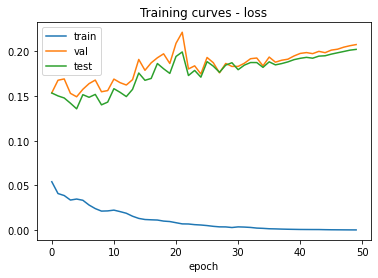

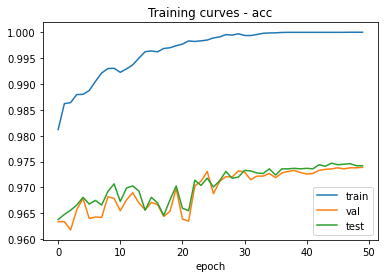

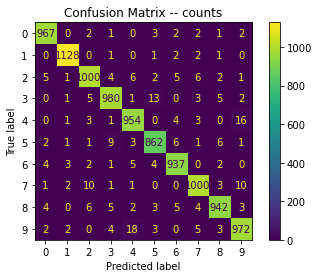

In [53]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])
res = plot_cm(three_layer_model, device, dataloaders, phase='test')

# Model with dropout

In [57]:
dropout = .25

# Simple three-hidden-layer classification model with dropout
class SimpleClassifier3LayerDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3LayerDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Reset the model with dropout
three_layer_dropout_model = SimpleClassifier3LayerDropout(input_size, hidden_size1, hidden_size2, hidden_size3, 
                         num_classes, dropout).to(device)
print(three_layer_dropout_model)    
    
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(three_layer_dropout_model.parameters(), lr=learning_rate, weight_decay=1e-2) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_dropout_model, training_curves_three_layer_dropout = train_model(three_layer_encoded_l2_dropout_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)

SimpleClassifier3LayerDropout(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

Epoch 1/50
----------
train Loss: 0.2912 Acc: 0.9200
val   Loss: 0.1872 Acc: 0.9500
test  Loss: 0.1750 Acc: 0.9502

Epoch 2/50
----------
train Loss: 0.2894 Acc: 0.9211
val   Loss: 0.1872 Acc: 0.9500
test  Loss: 0.1750 Acc: 0.9502

Epoch 3/50
----------
train Loss: 0.2893 Acc: 0.9218
val   Loss: 0.1872 Acc: 0.9500
test  Loss: 0.1750 Acc: 0.9502

Epoch 4/50
----------
train Loss: 0.2910 Acc: 0.9212
val   Loss: 0.1872 Acc: 0.9500
test  Loss: 0.1750 Acc: 0.9502

Epoch 5/50
----------

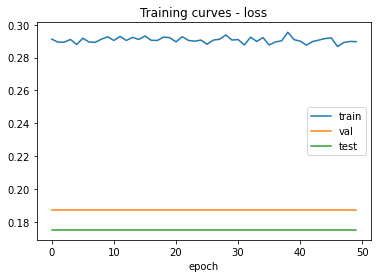

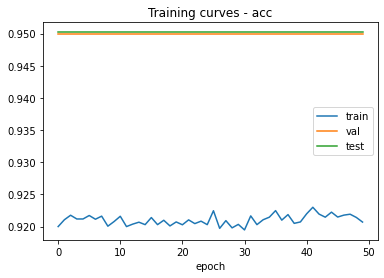

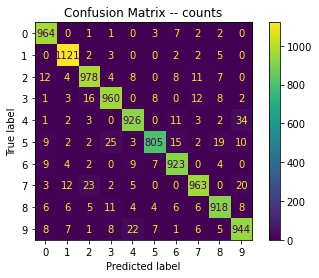

In [60]:
plot_training_curves(training_curves_three_layer_dropout, phases=['train', 'val', 'test'])
res = plot_cm(three_layer_dropout_model, device, dataloaders, phase='test')